# Project 5a - Population Dynamics: the Lotka-Volterra Equations

We have spent much of the semester considering physics - in particular motion of Newtonian particles under different forces and scenarios.  However, the framework that we've developed can be used for many other situations of scientific interest as well.  Here we turn to a major class of simulations that have been especially relevant over the course of the past few years: population dynamics. 

Such models are used in a variety of areas, and we will explore three over the course of this unit.  First, we will begin with a classic example from ecology.  This model was inspired by the following chart, which shows the total number of lynx and hare pelts collected by the Hudson's Bay Company between 1845 and 1935.  
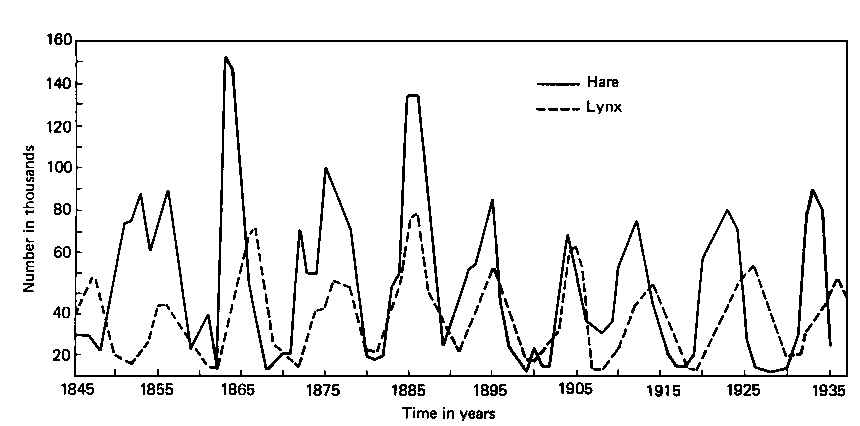

A few interesting things to consider about this plot.  First, both species experience cycles, similar to the oscillations that we've seen in planets, springs, and molecules.  Second, the cycles appear to be lagged: the peak number of hares preceds the peak number of lynx.  Third, *the cycles are not annual*.  It would be easy to attribute this to seasonal changes, but that is not the case.  So what's going on here?  

In an effort to explain these patterns, Lotka and Volterra both proposed the following model of dynamics.  Let's say that we have two populations of animals called $h$ and $l$ for hares and lynx.  Hares are subject to two processes.  First, they reproduce proportionally to the population size.  As such, in the absence of lynx (and in the absence of any other environmental limiters), we can write an approximate equation
$$
\frac{\partial h}{\partial t} = \alpha h,
$$
where $\alpha$ is a parameter that describes the birth rate minus the death rate of hares (per hare).  Of course this is a funny thing to write because we're dealing with discrete animals, but it's helpful to work in this slightly artifical paradigm in which we allow fractional hares.  This approximation becomes better as the number of hares increases.  

If we model this equation directly, we'll see that it has a pretty uninteresting solution
$$h(t) = h_0 \mathrm{e}^{\alpha t}.$$
This is the opposite of the coffee cup: rather than exponential decay, we have exponential growth without limit.  Fortunately, to avoid a world overrun by bunnies, we have lynx to keep the population in check.  In particular, we hypothesize that the number of bunnies eaten by lynx is proportional to the frequency of their interactions, which in turn is proportional to both of their population sizes.  A simple interaction term can thus be added to the hare dynamics as 
$$
\frac{\partial h}{\partial t} = \alpha h - \beta h l.
$$
Of course we also need to know the lynx population which might vary as well.  We'll assume that lynx reproduce proportionally to their food supply, which is to say that they convert rabbits into lynx.  Lynx also die of natural causes at a rate proportional to their population.  Combining these two ideas we have
$$
\frac{\partial l}{\partial t} = \gamma h l - \delta l.
$$
These two ODEs above are the Lotka-Volterra equations.  

### Model implementation

**Create a Lotka-Volterra problem class as before.  This should be very simple relative to what you've been working on recently.  Use as an initial condition 100 hares and 20 lynx.  Choose $\alpha=0.1,\beta=0.01,\gamma=0.002,\delta=0.1$.  (This roughly corresponds to highly effective but slowly reproducing lynx).  Integrate the equations for long enough to get a complete sense of the system's dynamics using a second-order Runge-Kutta method (either the [midpoint method](https://en.wikipedia.org/wiki/Midpoint_method) or [Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method)).  Describe the qualitative aspects of the system's dynamics.  Explore different parameters and initial conditions and try to proved a quantitative explanation for why these perhaps surprising dynamics occur.**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LotkaVolterra:
    def __init__(self, alpha=0.1, beta=0.01, gamma=0.002, delta=0.1, num_hare=100, num_lynx=20, uses_cc = False, K=100):
        self.alpha = alpha # describe the birth rate minus the death rate of the prey
        self.beta = beta 
        self.gamma = gamma
        self.delta = delta
        self.state = np.array([num_hare, num_lynx], dtype=float)
        self.K = K
        self.uses_cc = uses_cc

    def rhs(self, u):
        # RHS of the ODE
        hares, lynx = u
        if self.uses_cc:
            dhares = self.alpha * hares * (1 - hares / self.K) - self.beta * hares * lynx # dh/dt = ah(1-h/k) - bh*l
        else: 
            dhares = self.alpha * hares - self.beta * hares * lynx # dh/dt = ah - bh*l
        dlynx = self.gamma * hares * lynx - self.delta * lynx # dl/dt = gh*l - dl
        return np.array([dhares, dlynx])

class Heun:
    def step(self, model, dt, state):
        # Heun's method
        k1 = model.rhs(state)
        state += dt * k1
        k2 = model.rhs(state)
        return state + dt * (k2 - k1) / 2

class Integrator:
    def __init__(self, ode, method):
        # ode is provided as one of the model classes, method is one of the integrator classes
        self.ode = ode  # store the ode
        self.method = method  # store the method
    
    def integrate(self, interval, dt, u_0):
        # interval is a list [t_0, t_end], dt is the time step, u_0 is the initial state
        t_0 = interval[0]  # initial time
        t_end = interval[1]  # final time
        times = [t_0]  # list to store the times
        states = [u_0]  # list to store the states
        t = t_0  # current time
        u = u_0  # current state
        while t < t_end:
            dt_ = min(dt, t_end - t)  # time step
            u = self.method.step(self.ode, dt_, u)  # integrate the ODE
            t = t + dt_  # update the time
            times.append(t)  # store the time
            states.append(u)  # store the state
        return np.array(times), np.array(states)  # return the times and states as numpy arrays

In [ ]:
# Define the parameters for the Lotka-Volterra model
alpha = 0.1
beta = 0.01
gamma = 0.002
delta = 0.1
num_hare = 100 # steady is gamma/delta
num_lynx = 20 # steady is alpha/beta

# Define the initial state for the Lotka-Volterra model
u_0 = np.array([num_hare, num_lynx], dtype=float)

# Define the time interval and the time step for the integration
t_0 = 0
t_end = 200
dt = 0.001
# time of 200 with a time step of 0.001 gives 200,000 steps

# Create the Lotka-Volterra model
ode = LotkaVolterra(alpha, beta, gamma, delta, num_hare, num_lynx)

# Create the Heun method
heun = Heun()

# Create the integrator
integrator = Integrator(ode, heun)

# Perform the integration
times, states = integrator.integrate([t_0, t_end], dt, u_0)

# Plot the results
plt.plot(times, states[:, 0], label='Hares')
plt.plot(times, states[:, 1], label='Lynx')
plt.xlabel('Time')
plt.ylabel('Number of animals')
plt.legend()
plt.show()

### Phase plots

One nice way of understanding potential stable points of oscillatory systems is to produce a phase portrait, which in this case means a 2D plot (hares on the x-axis, lynx on the y-axis) of multiple solutions for different initial conditions.  **Using the same parameters as in the previous section, make a phase portrait.  For initial conditions, I started with 100 hares and $c$ lynx with $c\in\{10,20,30,40,50,60,70,80,90,100\}$.  Using this figure, try to determine the fixed point (i.e. the number of hares and lynx that are in exact balance and do not change in time).**  You can also determine this fixed point analytically by setting the time derivatives of the Lotka-Volterra equations to zero and solving for $h$ and $l$.  **Solve for the fixed point and put this on the phase plot as well**.


In [ ]:
# Define the parameters for the Lotka-Volterra model
alpha = 0.1
beta = 0.01
gamma = 0.002
delta = 0.1
num_hare = 100
lynx = [10,20,30,40,50,60,70,80,90,100]

# Define the time interval and the time step for the integration
t_0 = 0
t_end = 200
dt = 0.001
# time of 200 with a time step of 0.001 gives 200,000 steps

plots = []

# loop over each item in lynx and create a plot for each
for i in lynx:
    # Define the initial state for the Lotka-Volterra model
    u_0 = np.array([num_hare, i], dtype=float)

    # Create the Lotka-Volterra model
    ode = LotkaVolterra(alpha, beta, gamma, delta, num_hare, i)

    # Create the Heun method
    heun = Heun()

    # Create the integrator
    integrator = Integrator(ode, heun)

    # Perform the integration
    times, states = integrator.integrate([t_0, t_end], dt, u_0)

    # Plot the results
    plots.append(plt.plot(states[:, 0], states[:, 1], label=f'Lynx: {i}'))

plt.xlabel('Hares')
plt.ylabel('Lynx')

# add steady state lines
for i in lynx:
    plt.axhline(y=alpha/beta, color='r', linestyle='--')
    plt.axvline(x=gamma/delta, color='g', linestyle='--')

# show values of the lines
plt.text(100, 20, 'Steady state of Lynx: {}'.format(alpha/beta), color='r')
plt.text(50, 100, 'Steady state of Hares: {}'.format(gamma/delta), color='g')

plt.legend()
plt.show()

The plot above shows the phase portrait of the Lotka-Volterra equations.  The fixed point is the point at which the two populations are in balance.  This is the point at which the time derivatives of the populations are zero.  In other words, the fixed point is the point at which the populations do not change in time.  This is a stable point in the sense that if the populations are perturbed slightly from this point, they will return to it.  The fixed point is given analytically below.

To solve for the steady state, we set the time derivatives to zero and solve for $h$ and $l$.  This gives us the following equations:
$$
\begin{align}
0 &= \alpha h - \beta h l,\\
0 &= \gamma h l - \delta l.
\end{align}
$$
The first equation gives us $l = \alpha/\beta$.  Solving the second equation gives us $h = \delta/\gamma$.  This is the fixed point of the system.

### Carrying capacity
The Lotka-Volterra equations are often not quite realistic for real applications because they assume that hares grow without bound in the absence of Lynx.  In reality, an environment can only support so many animals before it reaches its [carrying capacity](https://en.wikipedia.org/wiki/Carrying_capacity).  We can amend our model of hare growth (ignoring lynx for now) by instead considering the model
$$
\frac{\partial h}{\partial t} = \alpha h \left(1 - \frac{h}{K}\right),
$$
where $K$ is the system's carrying capacity.  This simple ODE has the analytical solution
$$
h(t) = \frac{K}{1 + \left(\frac{K}{h_0} - 1\right)e^{-\alpha t}},
$$
where $h_0$ is the initial number of hares.  **Plot this solutions as a function of time for some reasonable initial conditions, a carrying capacity of $K=100$ and $\alpha$ as above.  Students who have taken Machine Learning (especially grad students), what shape is this curve?**

In [ ]:
def carrying_capacity(K, alpha, h0, t):
    return K / (1 + (K/h0 - 1) * np.exp(-alpha * t))

K = 100
alpha = 0.1
h0 = 1
t = np.linspace(0, 100, 1000)
plt.plot(t, carrying_capacity(K, alpha, h0, t))
plt.xlabel('Time')
plt.ylabel('Number of hares')
plt.show()

The shape of the plot above appears to follow a sigmoidal curve.  This is the same shape as the logistic / sigmoid function used in machine learning.

Finally, let's see how this change affects the hare-lynx dynamics.  Create a new Lotka-Volterra With Carrying Capacity problem class, in which the hare equation has been replaced with 
$$
\frac{\partial h}{\partial t} = \alpha h \left(1 - \frac{h}{K}\right) - \beta h l
$$
**Perform the same experiments as above (plot solutions through time and also make phase portraits), with this new equation.  How do the dynamics of the system change?  What does this tell you about systems that exhibit periodicity between predator-prey populations versus those that don't?**  

In [ ]:
# Define the parameters for the Lotka-Volterra model
alpha = 0.1
beta = 0.01
gamma = 0.002
delta = 0.1
num_hare = 100 # steady is gamma/delta
num_lynx = 20 # steady is alpha/beta

# Define the initial state for the Lotka-Volterra model
u_0 = np.array([num_hare, num_lynx], dtype=float)

# Define the time interval and the time step for the integration
t_0 = 0
t_end = 200
dt = 0.001
# time of 200 with a time step of 0.001 gives 200,000 steps

# Create the Lotka-Volterra model
ode = LotkaVolterra(alpha, beta, gamma, delta, num_hare, num_lynx, uses_cc=True, K=100)

# Create the Heun method
heun = Heun()

# Create the integrator
integrator = Integrator(ode, heun)

# Perform the integration
times, states = integrator.integrate([t_0, t_end], dt, u_0)

# Plot the results
plt.plot(times, states[:, 0], label='Hares')
plt.plot(times, states[:, 1], label='Lynx')
plt.xlabel('Time')
plt.ylabel('Number of animals')
plt.legend()
plt.show()

In [ ]:
# Define the parameters for the Lotka-Volterra model
alpha = 0.1
beta = 0.01
gamma = 0.002
delta = 0.1
num_hare = 100
lynx = [10,20,30,40,50,60,70,80,90,100]

# Define the time interval and the time step for the integration
t_0 = 0
t_end = 200
dt = 0.001
# time of 200 with a time step of 0.001 gives 200,000 steps

plots = []

# loop over each item in lynx and create a plot for each
for i in lynx:
    # Define the initial state for the Lotka-Volterra model
    u_0 = np.array([num_hare, i], dtype=float)

    # Create the Lotka-Volterra model
    ode = LotkaVolterra(alpha, beta, gamma, delta, num_hare, i, uses_cc=True, K=100)

    # Create the Heun method
    heun = Heun()

    # Create the integrator
    integrator = Integrator(ode, heun)

    # Perform the integration
    times, states = integrator.integrate([t_0, t_end], dt, u_0)

    # Plot the results
    plots.append(plt.plot(states[:, 0], states[:, 1], label=f'Lynx: {i}'))

plt.xlabel('Hares')
plt.ylabel('Lynx')

# plot this point on the graph: (beta*l)/(alpha) - (1/K)
plt.scatter((beta*lynx[0])/(alpha) - (1/100), lynx[0], color='r', label='Steady state')

plt.legend()
plt.show()

--------

In [10]:
# pygame simulation of lynxes and hares.  hares will be blue dots and lynxes will be red dots
# when the lynxes are close to the hares, they will eat them and the hares will decrease
# when the lynxes are far from the hares, the hares will increase
# the lynxes will increase when they eat the hares and decrease when they are far from the hares
# the lynxes will die if they are too far from the hares
# the hares multiply when they are far from the lynxes and decrease when they are eaten by the lynxes

import pygame
import numpy as np
import random

# Initialize Pygame
pygame.init()

# Set up some constants
WIDTH, HEIGHT = 800, 600
BG_COLOR = pygame.Color('white')
HARE_COLOR = pygame.Color('blue')
LYNX_COLOR = pygame.Color('red')


# a class for hares and lynxes
class Animal:
    def __init__(self, x, y, color):
        self.x = x
        self.y = y
        self.color = color

    def move(self):
        self.x = (self.x + random.randint(-1, 1)) % WIDTH
        self.y = (self.y + random.randint(-1, 1)) % HEIGHT

    def draw(self, screen):
        pygame.draw.circle(screen, self.color, (self.x, self.y), 5)

# Create hare and lync object lists
hares = [Animal(random.randint(0, WIDTH), random.randint(0, HEIGHT), HARE_COLOR) for _ in range(100)]
lynxes = [Animal(random.randint(0, WIDTH), random.randint(0, HEIGHT), LYNX_COLOR) for _ in range(20)]

# Create the screen
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('Hares and Lynxes')

# Create a clock
clock = pygame.time.Clock()

# Run the simulation
running = True

while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Move the animals
    # lynx goes towards closest hare
    for lynx in lynxes:
        distances = [min((hare.x - lynx.x)**2, (WIDTH - hare.x + lynx.x)**2) + min((hare.y - lynx.y)**2, (HEIGHT - hare.y + lynx.y)**2) for hare in hares]
        closest_hare = hares[np.argmin(distances)]
        dx = closest_hare.x - lynx.x
        dy = closest_hare.y - lynx.y
        if abs(dx) > WIDTH / 2:
            dx = -np.sign(dx) * (WIDTH - abs(dx))
        if abs(dy) > HEIGHT / 2:
            dy = -np.sign(dy) * (HEIGHT - abs(dy))
        lynx.x = (lynx.x + np.sign(dx)) % WIDTH
        lynx.y = (lynx.y + np.sign(dy)) % HEIGHT
    # hare goes away from closest lynx
    for hare in hares:
        distances = [min((lynx.x - hare.x)**2, (WIDTH - lynx.x + hare.x)**2) + min((lynx.y - hare.y)**2, (HEIGHT - lynx.y + hare.y)**2) for lynx in lynxes]
        closest_lynx = lynxes[np.argmin(distances)]
        dx = closest_lynx.x - hare.x
        dy = closest_lynx.y - hare.y
        if abs(dx) > WIDTH / 2:
            dx = -np.sign(dx) * (WIDTH - abs(dx))
        if abs(dy) > HEIGHT / 2:
            dy = -np.sign(dy) * (HEIGHT - abs(dy))
        hare.x = (hare.x - np.sign(dx)) % WIDTH
        hare.y = (hare.y - np.sign(dy)) % HEIGHT
        # if the lynx is close to the hare, the hare will die
        if np.sqrt(dx**2 + dy**2) < 10:
            hares.remove(hare)
            if len(hares) == 0:
                running = False
            break

    # Draw the animals
    screen.fill(BG_COLOR)
    for hare in hares:
        hare.draw(screen)
    for lynx in lynxes:
        lynx.draw(screen)

    # Update the screen
    pygame.display.flip()

    # Delay to get 30 frames per second
    clock.tick(30)

# Quit Pygame
pygame.quit()